# Improving Anomaly Detection by Data Smoothing
###### July 2016

## Introduction
In the [*first part*](https://github.com/mclarknc/Anomaly-Detection/blob/master/Anomaly%20Detection.ipynb) of this series we developed an algorithm for anomaly detection in time-series data. Our data source was sensor measurements of a municipal water tank.  The measurements are taken every 20 minutes using a sensor package and software developed by Syliant, LLC. These data are fairly noisy; emptying and filling the tank results in water sloshing around inside the tank which appears as noise in the time-series data collected by the sensor.

While I was researching anomaly detection methods, I came across a paper (which I sadly cannot find again - it was probabably from Zare-Baghbidi et. al from University of Isfahan. I need to try to find a citation) which suggested that preprocessing noisy time-series data by smoothing can improve anomaly detection. It seems likely that this approach may work in our case as it may result in a better collection of typical centroids from the k-means clusterer.

Let's continue our exploration of anomaly detection in the water tank data by applying smoothing to the data as a preprocessing step.

## Smoothing
We will use a [*Savitsky-Golay filter*](http://central.scipy.org/item/49/1/savitzky-golay-filter) on the training data set. According to the documentation: "The Savitzky-Golay filter removes high frequency noise from data. It has the advantage of preserving the original shape and features of the signal better than other types of filtering approaches, such as moving averages techniques."

Let's prepare the training data once again and plot it:

In [1]:
# load libraries and set plot parameters
import numpy as np
from scipy.signal import savgol_filter

from anomaly_utils import segment, plot_segments, window_segments, cluster, reconstruct, init_pyplot

import matplotlib.pyplot as plt
%matplotlib inline

init_pyplot()

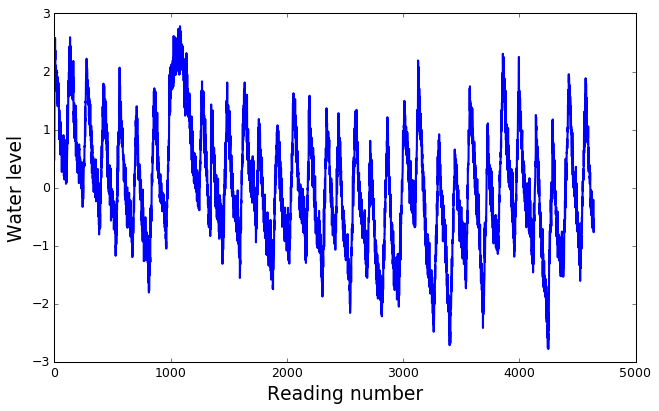

In [2]:
data = open('watertank_data.csv').readlines()
points = [float(p.strip()) for p in data]
all_data = np.array(points)
# lets take half of the input data for training, and half for testing
# and create numpy arrays
half = int(len(points)/2)
train_data = all_data[:half]

# scale the data top be centered on zero
from sklearn import preprocessing
train = preprocessing.scale(np.copy(train_data))

plt.plot(train)
plt.xlabel("Reading number")
plt.ylabel("Water level")

And now apply the smoothing filter and plot:

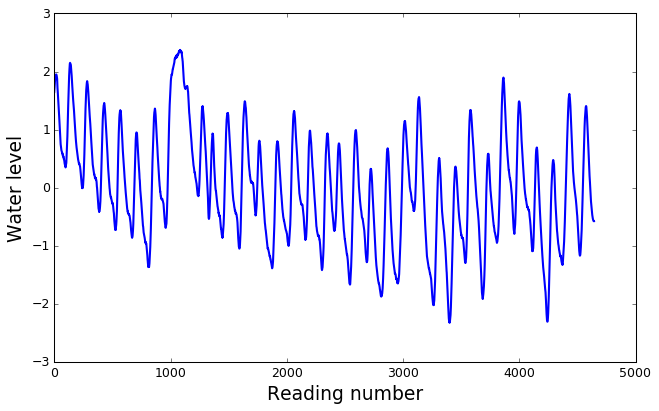

In [3]:
smoothed_train = savgol_smoothed = savgol_filter(train, 51, 2)
plt.plot(smoothed_train)
plt.xlabel("Reading number")
plt.ylabel("Water level")

Smooth!

Now let's apply the same sequence of steps to the smoothed data: segment, window, cluster, reconstruct:

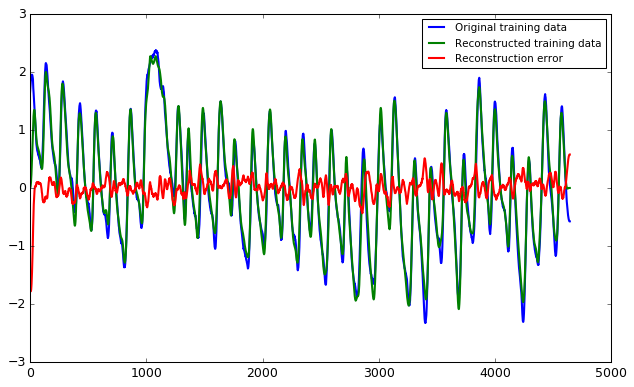

In [4]:
segment_length = 90
step_size = 9
num_clusters = 40

# segment the data
segments = segment(smoothed_train, segment_length, step_size)

# apply window function to all segments
windowed_segments = window_segments(segments, segment_length) 

# cluster the segments
clusterer = cluster(windowed_segments, num_clusters)

# reconstruct the training time-series
reconstructed_data = reconstruct(smoothed_train, segment_length, clusterer)
error = reconstructed_data - smoothed_train

# plot the results
plt.plot(smoothed_train, label="Original training data")
plt.plot(reconstructed_data, label="Reconstructed training data")
plt.plot(error, label="Reconstruction error")
plt.legend()
plt.show()

Looks good, let's look at the max and 98th percentile reconstruction error:

In [5]:
max_error = error.max()
error_98th_percentile = np.percentile(error, 98)
print('The maxiumum reconstruction error is: {:0.2f}'.format(max_error))
print('The 98th percentile of reconstruction error is: {:0.2f}'.format(error_98th_percentile))

The maxiumum reconstruction error is: 0.58
The 98th percentile of reconstruction error is: 0.33


Much better - reconstruction error using smoothed data is almost half of the unsmoothed data!


### What causes that reconstruction error?
However.  If you look at the reconstruction error at the beginning and end of the sample, you will notice that it is large compared to the error everywhere else. This is almost certainly due to applying the sinusoidal window function to the segmented data before we clustered it, which had the effect of forcing the beginning and ending of each cluster centroid to zero. If our input signal does not begin and end on or near zero - as it the case here - it will result in the reconstruction error shown.

In the [*next section*](https://github.com/mclarknc/Anomaly-Detection/blob/master/Anomaly%20Detection%20in%20Practice.ipynb) I will test out this anomaly detection technique on some simulated anomalous data.